# Basics of BNP-Step

This tutorial will help you get started using BNP-Step to analyze time-series data sets. We assume that users have basic familiarity with Python and installing packages.

## Installation

Installation instructions can be found in the readme on the main repository page [here](https://github.com/arojewski/bnp-step).

## Basic usage

To get started, first import the BNPStep class:

In [1]:
import bnpstep as bnp

Next, create a fresh BNPStep object. 

In [2]:
sampler = bnp.BNPStep()

To load a data set, first ensure your data set is in the same directory as the BNP-Step source files. Next, load your data set using the load_data() method.
Currently, accepted formats are:

    .txt, no time points, with each observation delimited by a newline (\n)
        Example: 62.6
                 42.3
                 53.4
                 68.8
                 ...
                 
    .txt with time points, with times first and observations second, separated by a comma (no space).
    Each time, observation pair is delimited by a newline.
        Example: 1.0,62.6
                 2.0,42.3
                 3.0,53.4
                 4.0,68.8
                 ...

    .csv, no time points. Observations can be as a single column or single row.

    .csv with time points. Time points are in the first column, while observations are in the second column. There should be only one time, observation pair per row.

The filename argument takes the filename of your data set (including the extension), while the has_timepoints argument indicates whether your file contains time points. Included with this tutorial code is an example data set test_data.csv, which we'll now load:

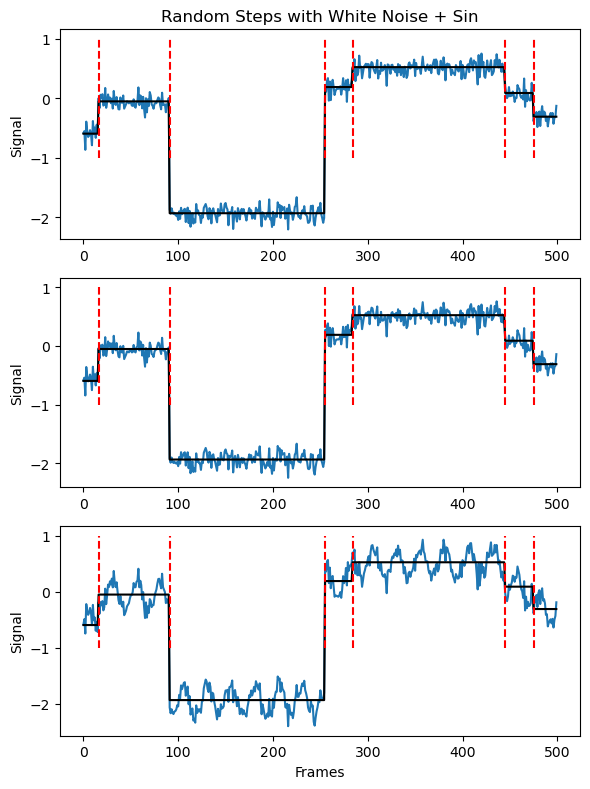

In [3]:
# JS Edit generate data (chatGPT helped) because I can't find given test_data.csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

randomseed = 0
np.random.seed(randomseed)  # for reproducibility

# Parameters
Anoise = [0.01, 0.05, 0.2]
duration = 500  # seconds
dt = 1  # sampling interval

# Uniform time base
t_uniform = np.arange(0, duration, dt)
# Step signal with random step times
n_steps = np.random.randint(6, 8)  # 6–7 steps
step_times = np.sort(np.random.choice(t_uniform[1:-1], n_steps, replace=False))
step_times = np.concatenate([[0], step_times, [duration]])
# Generate step values
step_values = np.random.randn(len(step_times) - 1)  # random level for each segment

# Create step signal
signal_step = np.zeros_like(t_uniform, dtype=float)
for i in range(len(step_values)):
    mask = (t_uniform >= step_times[i]) & (t_uniform < step_times[i+1])
    signal_step[mask] = step_values[i]

# Add white noise
signal_step_noisy = signal_step + 0.1 * np.random.randn(len(signal_step))

# Initialize plotting
fig, ax = plt.subplots(len(Anoise),1, figsize=(6, 8))

for index, Avalue in enumerate(Anoise):
    
    # Add some sinusoidal noise
    signal_step_noisy += Avalue * np.sin(2 * np.pi * t_uniform / 25)

#     plt.subplot(len(Anoise), index+1, 1)
    ax[index].plot(t_uniform, signal_step_noisy, label='Noisy Step Signal')
    ax[index].plot(t_uniform, signal_step, 'k-', label='Ground truth')
    for i in range(1, len(step_times)-1):
        ax[index].plot(step_times[i]*np.ones(2), [-1,1], 'r--')
    
    ax[index].set_ylabel('Signal')
    if Avalue == Anoise[-1]:
        ax[index].set_xlabel('Frames')
    if Avalue == Anoise[0]:
        ax[index].set_title('Random Steps with White Noise + Sin')
#     ax[index].legend()

    # Create DataFrame
    df = pd.DataFrame({
        'time': t_uniform,
        'signal': signal_step_noisy,
        'ground truth' : signal_step
    })

    # Export without column titles
    df.to_csv('bnpstep_parameter_optimization/sample_' +str(randomseed)+ '_noise_' +str(Avalue)+ '.csv', index=False, header=False)

plt.tight_layout()
plt.show()

In [4]:
sampler.load_data('bnpstep_parameter_optimization/sample_' +str(randomseed)+ '_noise_' +str(Avalue)+ '.csv', has_timepoints=True)

We can visualize our data set using the plot_data() method:

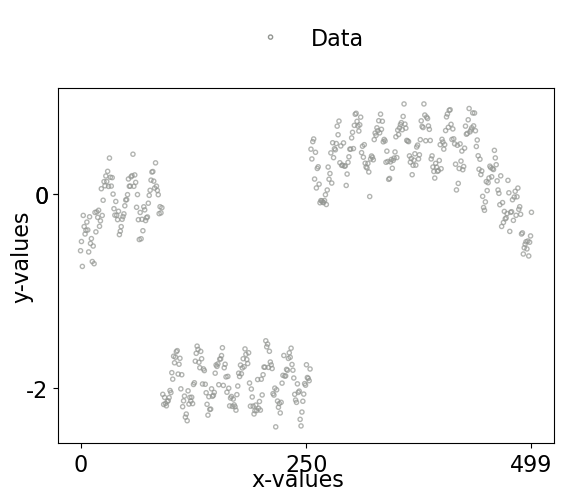

In [5]:
sampler.plot_data()

Now, let's analyze this data using BNP-Step. To analyze the data set you've loaded, call the analyze() method. By default, 40,000 samples will be generated, but if you'd like more or less, you can choose the number of samples to generate by changing the num_samples argument. To demonstrate this, let's generate 1,000 samples:

In [6]:
sampler.analyze(num_samples=1000)

/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:399: RuntimeWarning: invalid value encountered in scalar add
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
/Users/slivka/Documents/GitHub/bnp-step/bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


Once analysis is complete, you can save your results to disk as a .pkl file for later analysis using results_to_file(). The default output file name is 'output', but if you'd like a different name you can change the outfile argument.

In [7]:
sampler.results_to_file(outfile='samples')

If you check the directory where BNP-Step is running, you should now see a file called 'samples.pkl'. Next, let's try visualizing our results using the visualize_results() method. By default, this will generate a plot of the trajectory learned by BNP-Step overlaid upon the data set. You can also explicitly choose the type of plot to display by setting the plot_type argument to one of the following values:

'step' -- Generates a plot of the MAP estimate trajectory

'hist_step_height' -- Generates a histogram of all step heights from all samples with the MAP number of steps. This represents the joint posterior distribution for all h_m, conditioned on the MAP number of steps. 

'hist_dwell_time' -- Generates a histogram of all holding times from all samples with the MAP number of steps. This represents the joint posterior distribution for all holding times, conditioned on the MAP number of steps.

'hist_emission' -- Generates a histogram of all emission levels from all samples with the MAP number of steps. This represents the joint posterior distribution for all emission levels, conditioned on the MAP number of steps.

We will soon add the option to plot each individual step height, holding time, and emission level separately. Additionally, options for additional plots (such as for F_bg and eta) will be added in the future.

After the figure is generated and displayed, it will be saved as a PDF with the default name 'figure_(plot_type).pdf'. For example, after running the cell below, you'll find a PDF titled 'figure_step.pdf' in the directory in which BNP-Step is running. If you want to name the figure something else, change the fig_savename argument.

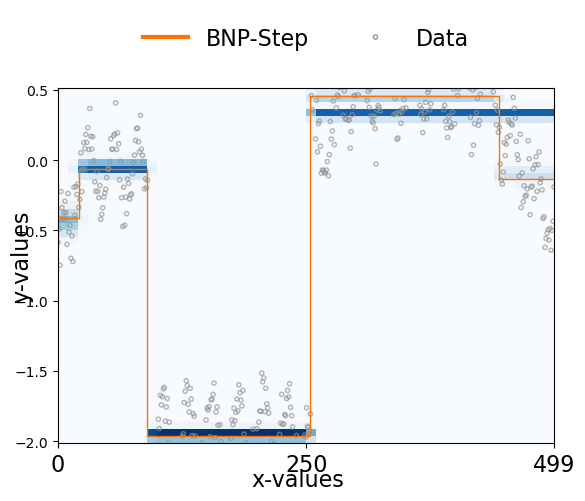

In [8]:
sampler.visualize_results(plot_type='step')

Finally, if you want to load and display results you have previously saved, you can do so with the results_from_file() method. Note that BNP-Step will look for the results file in the directory in which it is currently running. Additionally, you will need to reload the dataset if you want to display the results. As an example, let's create a new BNPStep object, reload the data set, load the results we saved above, and generate a histogram of the step heights.

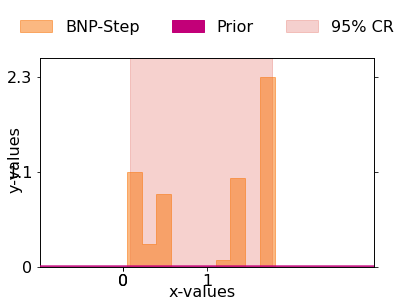

In [38]:
sampler2 = bnp.BNPStep()
sampler2.load_data("test_data.csv", has_timepoints=True)
sampler2.results_from_file(filename='samples')
sampler2.visualize_results(plot_type='hist_step_height')


By default histograms are generated with 95% credible intervals (CIs) and with the prior overlaid. If you don't want these to appear, you can turn them off by setting the arguments show_ci and show_prior to False. Let's also choose a new name for our new figure (so the old one doesn't get overwritten) by changing the fig_savename argument.

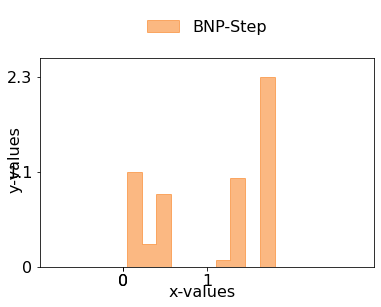

In [39]:
sampler2.visualize_results(plot_type='hist_step_height', show_ci=False, show_prior=False, fig_savename='figure2')

## Trying with real MINFLUX dynein data

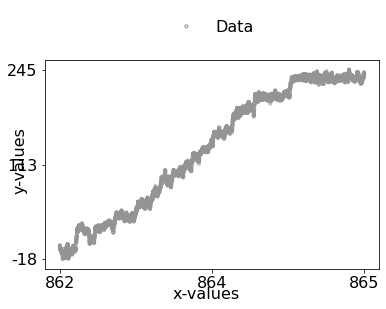

In [71]:
sampler.load_data("250713-144052_M10_127294_fiona.csv", has_timepoints=True)
sampler.plot_data()

C:\Users\yildi\Documents\GitHub\bnp-step\bnpsampler.py:344: RuntimeWarning: divide by zero encountered in log
  new_log_likelihood = ((num_data / 2) * np.log(eta_vec[-1] / (2 * np.pi))) - exponent_term
C:\Users\yildi\Documents\GitHub\bnp-step\bnpsampler.py:393: RuntimeWarning: divide by zero encountered in log
  prior_eta = ((phi - 1) * np.log(eta_vec[-1])) - ((phi * eta_vec[-1]) / eta_ref) - np.log(sp.special.gamma(phi)) - \
C:\Users\yildi\Documents\GitHub\bnp-step\bnpsampler.py:399: RuntimeWarning: invalid value encountered in double_scalars
  log_posterior = log_likelihood + prior_b_m + prior_h_m + prior_t_m + prior_eta + prior_f
C:\Users\yildi\Documents\GitHub\bnp-step\bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


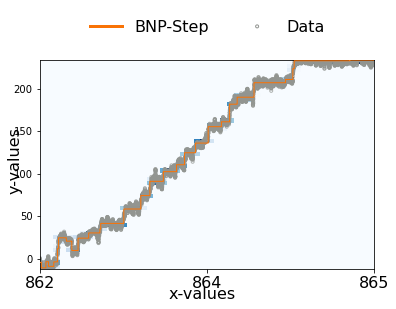

In [72]:
sampler.analyze(num_samples=1000)
# sampler.results_to_file(outfile='fiona_sample')
sampler.visualize_results(plot_type='step')

In [73]:
sampler.results_to_file(outfile='fiona_sample')

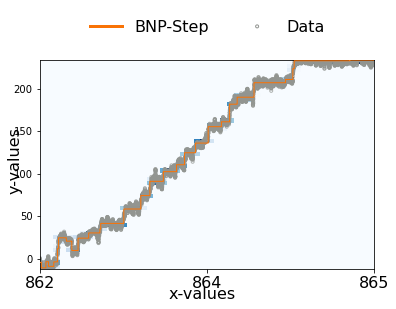

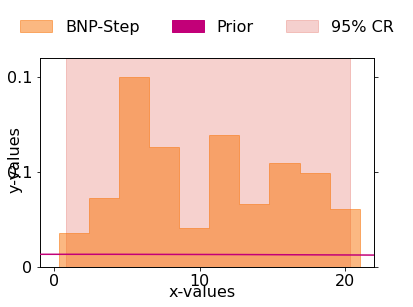

In [76]:
sampler2 = bnp.BNPStep()
sampler2.load_data("250713-144052_M10_127294_fiona.csv", has_timepoints=True)
sampler2.results_from_file(filename='250713-144052_M10_127294_fiona_sample')
# sampler2.visualize_results(plot_type='step')
sampler2.visualize_results(plot_type='hist_step_height')

In [82]:
sampler4 = bnp.BNPStep()

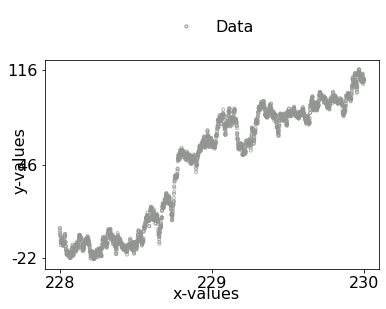

In [83]:
sampler4.load_data("250713-123520_M4_11757_fiona.csv", has_timepoints=True)
sampler4.plot_data()

In [84]:
sampler4.analyze(num_samples=1000)
sampler4.results_to_file(outfile='250713-123520_M4_11757_fiona_sample')

C:\Users\yildi\Documents\GitHub\bnp-step\bnpsampler.py:250: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = (1 / (np.exp(exponent_prop + exponent_old))) ** (1 / temp)


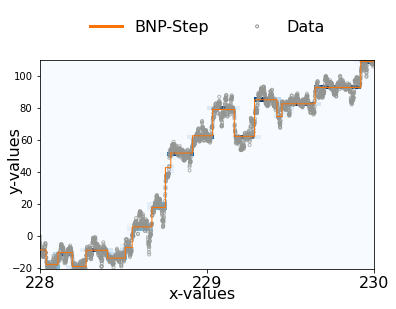

In [85]:
sampler4.visualize_results(plot_type='step')

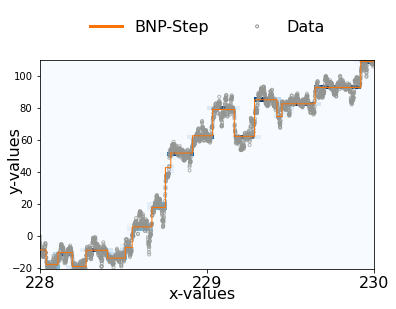

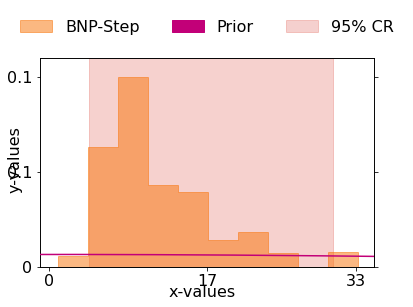

In [87]:
sampler4.results_from_file(filename='250713-123520_M4_11757_fiona_sample')
sampler4.visualize_results(plot_type='step')
sampler4.visualize_results(plot_type='hist_step_height')

## Advanced features

Coming soon!